In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

# Summary of the data

Data is from [Inside AirBNB](http://insideairbnb.com/get-the-data.html). There are five files provided (filenames changed to avoid redundancy). A data dictionary is [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896).

TODO talk about them using reviews as occupancy proxy.


- listings_summary.csv (was listings.csv)
    - condensed listings file
- listings.csv (was listings.csv.gz)
    - full listings data
- reviews_summary.csv (was reviews.csv)
    - dates of when reviews were.
- reviews.csv (was reviews.csv.gz)
    - full reviews data
- calendar.csv
    - availability calendar
    
Inspecting the data dict and the files, I decided to use only the listings summary and pull selected features from the full listings csv, as the reviews and calendar are partially captured and summarized in the listings csv anyways.

In [4]:
listings_summary = pd.read_csv('data/listings_summary.csv')
listings = pd.read_csv('data/listings.csv')
reviews_summary = pd.read_csv('data/reviews_summary.csv')
reviews = pd.read_csv('data/reviews.csv')
calendar = pd.read_csv('data/calendar.csv')

In [5]:
listings_summary.head()

id                                               name  host_id  \
0  10080                     D1 -  Million Dollar View 2 BR    30899   
1  13358  Monthly (or Longer ) Designer One Bedroom Down...    52116   
2  13490                       Vancouver's best kept secret    52467   
3  14267                                  EcoLoft Vancouver    56030   
4  16254        Close to PNE/Hastings Park and East Village    63238   

        host_name  neighbourhood_group             neighbourhood  latitude  \
0            Rami                  NaN                  Downtown  49.28872   
1            Lynn                  NaN                  West End  49.28201   
2            Iris                  NaN  Kensington-Cedar Cottage  49.25622   
3  Peter & Alison                  NaN  Kensington-Cedar Cottage  49.24922   
4           Jason                  NaN          Hastings-Sunrise  49.27721   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0 -123.12046  Entire home/apt    150              90                 16   
1 -123.12669  Entire home/apt     85              30                430   
2 -123.06607  Entire home/apt    145              30                 88   
3 -123.08139  Entire home/apt    140               3                 33   
4 -123.04086  Entire home/apt    195               3                  5   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2017-02-26               0.14                              40   
1  2021-01-01               3.27                               1   
2  2020-10-31               0.73                               1   
3  2020-02-07               0.26                               1   
4  2019-08-19               0.15                               1   

   availability_365  
0               346  
1                98  
2               203  
3               123  
4               289

In [6]:
listings.head()

id                         listing_url       scrape_id last_scraped  \
0  10080  https://www.airbnb.com/rooms/10080  20210412154228   2021-04-13   
1  13358  https://www.airbnb.com/rooms/13358  20210412154228   2021-04-13   
2  13490  https://www.airbnb.com/rooms/13490  20210412154228   2021-04-13   
3  14267  https://www.airbnb.com/rooms/14267  20210412154228   2021-04-13   
4  16254  https://www.airbnb.com/rooms/16254  20210412154228   2021-04-12   

                                                name  \
0                     D1 -  Million Dollar View 2 BR   
1  Monthly (or Longer ) Designer One Bedroom Down...   
2                       Vancouver's best kept secret   
3                                  EcoLoft Vancouver   
4        Close to PNE/Hastings Park and East Village   

                                         description  \
0  Stunning two bedroom, two bathroom apartment. ...   
1  <b>The space</b><br />This suites central loca...   
2  This apartment rents for one month blocks of t...   
3  The Ecoloft is located in the lovely, family r...   
4  2 Bedroom garden level guest suite.(lower leve...   

                               neighborhood_overview  \
0                                                NaN   
1                                                NaN   
2  In the heart of Vancouver, this apartment has ...   
3  We live in the centre of the city of Vancouver...   
4  Good Eats, Cute Shops and all the personality ...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/55778229/c2f7...    30899   
1  https://a0.muscache.com/pictures/c23bb7ef-e300...    52116   
2  https://a0.muscache.com/pictures/73394727/79d5...    52467   
3  https://a0.muscache.com/pictures/3646de9b-934e...    56030   
4  https://a0.muscache.com/pictures/90623667/583c...    63238   

                                  host_url       host_name  host_since  \
0  https://www.airbnb.com/users/show/30899            Rami  2009-08-10   
1  https://www.airbnb.com/users/show/52116            Lynn  2009-11-07   
2  https://www.airbnb.com/users/show/52467            Iris  2009-11-08   
3  https://www.airbnb.com/users/show/56030  Peter & Alison  2009-11-20   
4  https://www.airbnb.com/users/show/63238           Jason  2009-12-15   

                         host_location  \
0  Vancouver, British Columbia, Canada   
1  Vancouver, British Columbia, Canada   
2  Vancouver, British Columbia, Canada   
3  Vancouver, British Columbia, Canada   
4  Vancouver, British Columbia, Canada   

                                          host_about  host_response_time  \
0                       I will be happy to host you.      within an hour   
1  I am from Vancouver and in my free time enjoy ...        within a day   
2  Hello! My husband Fred and I are actors living...      within an hour   
3  We moved into this central Vancouver location ...  within a few hours   
4                                                NaN                 NaN   

  host_response_rate host_acceptance_rate host_is_superhost  \
0                93%                  87%                 f   
1               100%                  57%                 t   
2               100%                  78%                 t   
3               100%                  NaN                 f   
4                NaN                  NaN                 f   

                                  host_thumbnail_url  \
0  https://a0.muscache.com/im/pictures/user/55302...   
1  https://a0.muscache.com/defaults/user_pic-50x5...   
2  https://a0.muscache.com/im/users/52467/profile...   
3  https://a0.muscache.com/im/pictures/user/ab0a8...   
4  https://a0.muscache.com/im/pictures/user/f00ba...   

                                    host_picture_url  \
0  https://a0.muscache.com/im/pictures/user/55302...   
1  https://a0.muscache.com/defaults/user_pic-225x...   
2  https://a0.muscache.com/im/users/52467/profile...   
3  https://a0.muscache.com/im/pictures/user/ab

In [7]:
reviews_summary.head()

listing_id        date
0       10080  2011-11-15
1       10080  2011-12-14
2       10080  2012-03-12
3       10080  2012-06-05
4       10080  2013-01-15

In [8]:
reviews.head()

listing_id       id        date  reviewer_id reviewer_name  \
0       10080   720466  2011-11-15       143771       Anthony   
1       10080   786114  2011-12-14      1472653        Nilesh   
2       10080   989885  2012-03-12      1433564         Avril   
3       10080  1419559  2012-06-05       725806        Dennis   
4       10080  3354964  2013-01-15      3641867          Jude   

                                            comments  
0  this accommodation was excellent. beautiful sp...  
1  The host canceled my reservation 13 days befor...  
2  This apartment is fantastic, just what I and m...  
3  Very nice apartment and great view. Close to S...  
4  Both Rami and Mauricio made our family of 5 fe...

In [9]:
calendar.head()

listing_id        date available   price adjusted_price  minimum_nights  \
0       35304  2021-04-14         f  $75.00         $75.00             2.0   
1       35304  2021-04-15         t  $75.00         $75.00             2.0   
2       35304  2021-04-16         t  $75.00         $75.00             2.0   
3       35304  2021-04-17         t  $75.00         $75.00             2.0   
4       35304  2021-04-18         t  $75.00         $75.00             2.0   

   maximum_nights  
0            30.0  
1            30.0  
2            30.0  
3            30.0  
4            30.0

# Wrangling

## Listings Summary
This is what `listings_summary` looks like:

In [10]:
listings_summary.head()

id                                               name  host_id  \
0  10080                     D1 -  Million Dollar View 2 BR    30899   
1  13358  Monthly (or Longer ) Designer One Bedroom Down...    52116   
2  13490                       Vancouver's best kept secret    52467   
3  14267                                  EcoLoft Vancouver    56030   
4  16254        Close to PNE/Hastings Park and East Village    63238   

        host_name  neighbourhood_group             neighbourhood  latitude  \
0            Rami                  NaN                  Downtown  49.28872   
1            Lynn                  NaN                  West End  49.28201   
2            Iris                  NaN  Kensington-Cedar Cottage  49.25622   
3  Peter & Alison                  NaN  Kensington-Cedar Cottage  49.24922   
4           Jason                  NaN          Hastings-Sunrise  49.27721   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0 -123.12046  Entire home/apt    150              90                 16   
1 -123.12669  Entire home/apt     85              30                430   
2 -123.06607  Entire home/apt    145              30                 88   
3 -123.08139  Entire home/apt    140               3                 33   
4 -123.04086  Entire home/apt    195               3                  5   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2017-02-26               0.14                              40   
1  2021-01-01               3.27                               1   
2  2020-10-31               0.73                               1   
3  2020-02-07               0.26                               1   
4  2019-08-19               0.15                               1   

   availability_365  
0               346  
1                98  
2               203  
3               123  
4               289

In [11]:
listings_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4299 non-null   int64  
 1   name                            4299 non-null   object 
 2   host_id                         4299 non-null   int64  
 3   host_name                       4170 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   4299 non-null   object 
 6   latitude                        4299 non-null   float64
 7   longitude                       4299 non-null   float64
 8   room_type                       4299 non-null   object 
 9   price                           4299 non-null   int64  
 10  minimum_nights                  4299 non-null   int64  
 11  number_of_reviews               4299 non-null   int64  
 12  last_review                     34

`neighbourhood_group` is all NaN, so will be dropped.

I'm going to drop the `name` of the listing as well. Although there might be some correlation between the marketing value in a title, I don't plan on doing any text analysis.

`host_name` also will be dropped, as `host_id` will suffice for tracking hosts.



In [12]:
listings_summary = listings_summary.drop(labels=['neighbourhood_group', 'name', 'host_name'], axis=1)

## Listings

I'm going to grab only useful looking features of out this data.

In [13]:
listings.head(1)

id                         listing_url       scrape_id last_scraped  \
0  10080  https://www.airbnb.com/rooms/10080  20210412154228   2021-04-13   

                             name  \
0  D1 -  Million Dollar View 2 BR   

                                         description neighborhood_overview  \
0  Stunning two bedroom, two bathroom apartment. ...                   NaN   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/55778229/c2f7...    30899   

                                  host_url host_name  host_since  \
0  https://www.airbnb.com/users/show/30899      Rami  2009-08-10   

                         host_location                    host_about  \
0  Vancouver, British Columbia, Canada  I will be happy to host you.   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour                93%                  87%   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/pictures/user/55302...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/55302...       Coal Harbour   

   host_listings_count  host_total_listings_count  \
0                 49.0                       49.0   

                                  host_verifications host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'jumio', 'govern...                    t   

  host_identity_verified neighbourhood neighbourhood_cleansed  \
0                      t           NaN               Downtown   

   neighbourhood_group_cleansed  latitude  longitude       property_type  \
0                           NaN  49.28872 -123.12046  Entire condominium   

         room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds  \
0  Entire home/apt             5        NaN        2 baths       2.0   2.0   

                                           amenities    price  minimum_nights  \
0  ["Iron", "Dryer", "Bed linens", "Cooking basic...  $150.00              90   

   maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
0            1124                      90                      90   

   minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
0                    1124                    1124                    90.0   

   maximum_nights_avg_ntm  calendar_updated has_availability  availability_30  \
0                  1124.0               NaN                t               11   

   availability_60  availability_90  availability_365 calendar_last_scraped  \
0               41               71               346            2021-04-13   

   number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
0                 16                      0                       0   

  first_review last_review  review_scores_rating  review_scores_accuracy  \
0   2011-11-15  2017-02-26                  93.0                     9.0   

   review_scores_cleanliness  review_scores_checkin  \
0                        9.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                          9.0                    10.0                  9.0   

     license instant_bookable  calculated_host_listings_count  \
0  18-476608                f                              40   

   calculated_host_listings_count_entire_homes  \
0                                           40   

   calculated_host_listings_count_private_rooms  \
0                                             0   

   calculated_host_listings_count_shared_rooms  reviews_per_month  
0                                            0               0.14

In [14]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4299 non-null   int64  
 1   listing_url                                   4299 non-null   object 
 2   scrape_id                                     4299 non-null   int64  
 3   last_scraped                                  4299 non-null   object 
 4   name                                          4299 non-null   object 
 5   description                                   4272 non-null   object 
 6   neighborhood_overview                         3074 non-null   object 
 7   picture_url                                   4299 non-null   object 
 8   host_id                                       4299 non-null   int64  
 9   host_url                                      4299 non-null   o

After a cursory inspection, a number of features related to the host, the properties of the room, and the reviews seem interesting.

In [15]:
interesting_props_dict = {'host': ['host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
              'host_has_profile_pic', 'host_identity_verified'],
                          
                          'room': ['property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
               'amenities', 'instant_bookable'],
                          
                          'review': ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
               'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value']
                         }
                          

# DATA CLEANING
I'll now look through the datasets we have and clean them as necessary, i.e. checking for duplicates, dealing with NaN's, and adjusting datatypes.

For clarity, I'll break the cleaning into four parts for each of `listings_summary`, `listings_host`, `listings_room`, `listings_review`, before combining them back together again.

In [16]:
## .copy() prevents SettingWithCopy warnings later on in the pipeline
# Features related to the host from listings.csv
listings_host = listings[interesting_props_dict['host']].copy()
# Features related to the room from listings.csv
listings_room = listings[interesting_props_dict['room']].copy()
# Features related to reviews from listings.csv
listings_review = listings[interesting_props_dict['review']].copy()

## Helper functions for data cleaning
First, define a some helper functions for converting data types:

In [17]:
def convert_percent_to_float(string_percent):
    """
    Converts percentage strings to a float ratio e.g. 95% -> 0.95.
    
    For applying to dataframe elements. If element is NaN, returns back the element.
    """
    if pd.isna(string_percent):
        return string_percent
    else:
        return float(string_percent.strip('%'))/100

In [18]:
def convert_tf_to_float(string):
    """
    Converts strings of "t" and "f" to 1.0 or 0.0 floats.
    
    For applying to dataframe elements. If element is NaN, returns back the element.
    """ 
    if pd.isna(string):
        return string
    else:    
        return {'t':1, 'f':0}[string]

In [19]:
def convert_str_to_datetime(string, format='%Y-%m-%d'):
    """
    Converts strings of YYYY-MM-DD format (by default) to datetime objects.
    
    For applying to dataframe elements. If element is NaN, returns back the element.
    
    Uses pd.to_datetime.
    """ 
    return pd.to_datetime(string, format=format)
    

In [20]:
def col_apply_inplace(df, cols, f, **kwds):
    """
    Helper func to apply a func to elements of a column in-place.
    
    df   : input dataframe
    cols : single string or list of strings of column names
    f    : the function to apply to the elements of the columns
    kwds : keyword arguments to pass onto f
    """
    if type(cols) == str:
        df.loc[:,cols] = df.loc[:,cols].apply(f, **kwds)
    elif type(cols) == list:
        for col in cols:
            df.loc[:,col] = df.loc[:,col].apply(f, **kwds)
    else:
        raise ValueError('cols is not a single column name string or a list of column name strings')

For `listings_summary`, `last_review` needs to be converted to datetimes.

In [21]:
listings_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4299 non-null   int64  
 1   host_id                         4299 non-null   int64  
 2   neighbourhood                   4299 non-null   object 
 3   latitude                        4299 non-null   float64
 4   longitude                       4299 non-null   float64
 5   room_type                       4299 non-null   object 
 6   price                           4299 non-null   int64  
 7   minimum_nights                  4299 non-null   int64  
 8   number_of_reviews               4299 non-null   int64  
 9   last_review                     3499 non-null   object 
 10  reviews_per_month               3499 non-null   float64
 11  calculated_host_listings_count  4299 non-null   int64  
 12  availability_365                42

In [22]:
# Convert to datetime
col_apply_inplace(listings_summary, 'last_review', convert_str_to_datetime)

## `listings_host`

`listings_host` is an all string dataframe 

In [23]:
listings_host.head()

host_since  host_response_time host_response_rate host_acceptance_rate  \
0  2009-08-10      within an hour                93%                  87%   
1  2009-11-07        within a day               100%                  57%   
2  2009-11-08      within an hour               100%                  78%   
3  2009-11-20  within a few hours               100%                  NaN   
4  2009-12-15                 NaN                NaN                  NaN   

  host_is_superhost host_has_profile_pic host_identity_verified  
0                 f                    t                      t  
1                 t                    f                      t  
2                 t                    t                      t  
3                 f                    t                      t  
4                 f                    t                      t

In [24]:
listings_host.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   host_since              4170 non-null   object
 1   host_response_time      2991 non-null   object
 2   host_response_rate      2991 non-null   object
 3   host_acceptance_rate    3099 non-null   object
 4   host_is_superhost       4170 non-null   object
 5   host_has_profile_pic    4170 non-null   object
 6   host_identity_verified  4170 non-null   object
dtypes: object(7)
memory usage: 235.2+ KB


I'll need to convert t/f columns to 1.0 and 0.0 representing true and false, convert dates to datetimes, and percentages to ratios.

In [25]:
col_apply_inplace(listings_host, 'host_since', convert_str_to_datetime)

col_apply_inplace(listings_host, 
                  ['host_response_rate', 'host_acceptance_rate'], 
                  convert_percent_to_float)

col_apply_inplace(listings_host, 
                  ['host_is_superhost','host_has_profile_pic','host_identity_verified'], 
                  convert_tf_to_float)

In [26]:
listings_host.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   host_since              4170 non-null   datetime64[ns]
 1   host_response_time      2991 non-null   object        
 2   host_response_rate      2991 non-null   float64       
 3   host_acceptance_rate    3099 non-null   float64       
 4   host_is_superhost       4170 non-null   float64       
 5   host_has_profile_pic    4170 non-null   float64       
 6   host_identity_verified  4170 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 235.2+ KB


In [27]:
listings_host.head()

host_since  host_response_time  host_response_rate  host_acceptance_rate  \
0 2009-08-10      within an hour                0.93                  0.87   
1 2009-11-07        within a day                1.00                  0.57   
2 2009-11-08      within an hour                1.00                  0.78   
3 2009-11-20  within a few hours                1.00                   NaN   
4 2009-12-15                 NaN                 NaN                   NaN   

   host_is_superhost  host_has_profile_pic  host_identity_verified  
0                0.0                   1.0                     1.0  
1                1.0                   0.0                     1.0  
2                1.0                   1.0                     1.0  
3                0.0                   1.0                     1.0  
4                0.0                   1.0                     1.0

# ROOM CLEAN

`listings_room` has two columns of note. `bathrooms_text` are host-entered strings describing their bathroom situation, whereas `amenities` is are json formatted collections of various amenities the property has.

In [28]:
listings_room.head()

property_type        room_type  accommodates  bathrooms  \
0  Entire condominium  Entire home/apt             5        NaN   
1  Entire condominium  Entire home/apt             2        NaN   
2    Entire apartment  Entire home/apt             2        NaN   
3        Entire house  Entire home/apt             4        NaN   
4  Entire guest suite  Entire home/apt             4        NaN   

  bathrooms_text  bedrooms  beds  \
0        2 baths       2.0   2.0   
1         1 bath       1.0   1.0   
2         1 bath       1.0   1.0   
3         1 bath       1.0   2.0   
4         1 bath       2.0   3.0   

                                           amenities instant_bookable  
0  ["Iron", "Dryer", "Bed linens", "Cooking basic...                f  
1  ["Iron", "Dryer", "Bed linens", "Cooking basic...                f  
2  ["Iron", "Outdoor dining area", "Ethernet conn...                f  
3  ["Iron", "Dryer", "Cooking basics", "Hot water...                t  
4  ["Iron", "Dryer", "Bed linens", "Cooking basic...                t

In [29]:
listings_room.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   property_type     4299 non-null   object 
 1   room_type         4299 non-null   object 
 2   accommodates      4299 non-null   int64  
 3   bathrooms         0 non-null      float64
 4   bathrooms_text    4297 non-null   object 
 5   bedrooms          3987 non-null   float64
 6   beds              4263 non-null   float64
 7   amenities         4299 non-null   object 
 8   instant_bookable  4299 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 302.4+ KB


Inspecting the amenities, each property has a combination of many amenities. These aren't very standardized.

In [30]:
amen = listings_room['amenities'].copy()

In [31]:
amen.value_counts()

["Heating", "Kitchen", "Stove", "Microwave", "Dryer", "Washer", "Wifi", "Long term stays allowed", "TV", "Hot water", "Smoke alarm", "Oven"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Pulling out the individual amenities, it's a long-tailed distribution (i.e. most amenity types are present in low-count, but there are a lot of them).

In [32]:
amenity_series = pd.Series([item for sublist in amen for item in json.loads(sublist)]).value_counts()

In [33]:
amenity_series

Wifi                                                                                                                                                                4226
Heating                                                                                                                                                             4138
Smoke alarm                                                                                                                                                         4112
Essentials                                                                                                                                                          4001
Kitchen                                                                                                                                                             3986
Long term stays allowed                                                                                                                                    

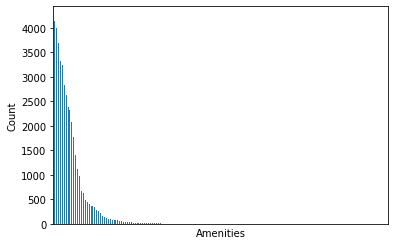

In [34]:
axes =  amenity_series.plot.bar()
# Turn off x-axis, otherwise x tick labels are a mess
axes.set_xticks([])
axes.set_xlabel('Amenities')
axes.set_ylabel('Count');


One way would be to pull out only the most popular amenities.

In [35]:
amenity_series.describe()

count     495.000000
mean      243.573737
std       760.174209
min         1.000000
25%         1.000000
50%         1.000000
75%        18.500000
max      4226.000000
dtype: float64

In [36]:
amenity_series.index[amenity_series >= 20].size

123

In [37]:
amenity_series.index[amenity_series >= 1000].size

38

An arbitrary threshold of having at least a count of 1000 might be reasonable

In [38]:
amenities_to_keep = amenity_series.index[amenity_series >= 1000]
# Make an zeros df
amenities_df = pd.DataFrame(np.zeros([listings_room.shape[0], amenities_to_keep.size]), columns=amenities_to_keep)

# Fill in the df by for loop, 1/0, basically dummy columns.
# Seems pretty slow.
for i, item in enumerate(listings_room['amenities']):
    amenities = json.loads(item)
    for amenity in amenities:
        amenities_df.iloc[i,:].loc[amenity] = 1

In [39]:
# Checking to see if correctly populated, by comparing to next cell
amenities_df.head()

Wifi  Heating  Smoke alarm  Essentials  Kitchen  Long term stays allowed  \
0   1.0      1.0          1.0         0.0      1.0                      1.0   
1   1.0      1.0          1.0         1.0      1.0                      1.0   
2   1.0      0.0          1.0         1.0      1.0                      1.0   
3   1.0      1.0          1.0         1.0      1.0                      1.0   
4   1.0      0.0          1.0         1.0      1.0                      1.0   

   Hangers  Washer  Dryer  Hair dryer  Hot water  Iron  Shampoo  \
0      1.0     1.0    1.0         1.0        1.0   1.0      0.0   
1      1.0     1.0    1.0         1.0        1.0   1.0      1.0   
2      1.0     0.0    1.0         1.0        1.0   1.0      1.0   
3      1.0     1.0    1.0         1.0        1.0   1.0      1.0   
4      1.0     1.0    1.0         1.0        1.0   1.0      1.0   

   Dedicated workspace   TV  Carbon monoxide alarm  Dishes and silverware  \
0                  1.0  0.0                    1.0                    1.0   
1                  1.0  0.0                    1.0                    1.0   
2                  0.0  0.0                    1.0                    1.0   
3                  1.0  1.0                    0.0                    1.0   
4                  1.0  0.0                    1.0                    1.0   

   Fire extinguisher  Refrigerator  Cooking basics  Microwave  Coffee maker  \
0                0.0           1.0             1.0        1.0           1.0   
1                0.0           1.0             1.0        1.0           1.0   
2                1.0           1.0             1.0        1.0           1.0   
3                1.0           1.0             1.0        1.0           1.0   
4                1.0           1.0             1.0        1.0           1.0   

   Stove  Oven  Free parking on premises  Private entrance  Bed linens  \
0    1.0   0.0                       1.0               0.0         1.0   
1    1.0   1.0                       0.0               0.0         1.0   
2    1.0   1.0                       1.0               1.0         1.0   
3    1.0   1.0                       0.0               0.0         0.0   
4    1.0   1.0                       1.0               1.0         1.0   

   Free street parking  Dishwasher  First aid kit  Patio or balcony  \
0                  0.0         1.0            0.0               0.0   
1                  0.0         1.0            0.0               0.0   
2                  1.0         1.0            0.0               1.0   
3                  1.0         1.0            0.0               0.0   
4                  1.0         0.0            0.0               1.0   

   Extra pillows and blankets  Elevator  Cable TV  Luggage dropoff allowed  \
0                         0.0       1.0       1.0                      0.0   
1                         1.0       1.0       1.0                      0.0   
2                         0.0       0.0       1.0                      1.0   
3                         0.0       0.0       0.0                      0.0   
4                         1.0       0.0       0.0                      1.0   

   Air conditioning  Gym  Backyard  
0               1.0  1.0       0.0  
1               1.0  1.0       0.0  
2               0.0  1.0       0.0  
3               0.0  0.0       0.0  
4               0.0  0.0       0.0

In [40]:
listings_room.iloc[0,:]['amenities']

'["Iron", "Dryer", "Bed linens", "Cooking basics", "Elevator", "Hot water", "Indoor fireplace", "Dishes and silverware", "Stove", "Microwave", "Long term stays allowed", "TV with standard cable", "Refrigerator", "Hangers", "Pool", "Air conditioning", "Hair dryer", "Cable TV", "Gym", "Washer", "Wifi", "Carbon monoxide alarm", "Dedicated workspace", "Free parking on premises", "Smoke alarm", "Heating", "Kitchen", "Coffee maker", "Dishwasher", "Host greets you"]'

I'll prefix the columns in `amenities_df`, then drop the `amenities` column in `listings_room`, before glueing `amenities_df` back on:

In [41]:
amenities_df.columns = amenities_df.columns.str.lower()

In [42]:
amenities_df.columns = 'amenity_' + amenities_df.columns

In [43]:
listings_room = listings_room.drop(labels=['amenities'], axis=1)

In [44]:
listings_room = pd.concat([listings_room, amenities_df], axis=1)

In [45]:
listings_room.head()

property_type        room_type  accommodates  bathrooms  \
0  Entire condominium  Entire home/apt             5        NaN   
1  Entire condominium  Entire home/apt             2        NaN   
2    Entire apartment  Entire home/apt             2        NaN   
3        Entire house  Entire home/apt             4        NaN   
4  Entire guest suite  Entire home/apt             4        NaN   

  bathrooms_text  bedrooms  beds instant_bookable  amenity_wifi  \
0        2 baths       2.0   2.0                f           1.0   
1         1 bath       1.0   1.0                f           1.0   
2         1 bath       1.0   1.0                f           1.0   
3         1 bath       1.0   2.0                t           1.0   
4         1 bath       2.0   3.0                t           1.0   

   amenity_heating  amenity_smoke alarm  amenity_essentials  amenity_kitchen  \
0              1.0                  1.0                 0.0              1.0   
1              1.0                  1.0                 1.0              1.0   
2              0.0                  1.0                 1.0              1.0   
3              1.0                  1.0                 1.0              1.0   
4              0.0                  1.0                 1.0              1.0   

   amenity_long term stays allowed  amenity_hangers  amenity_washer  \
0                              1.0              1.0             1.0   
1                              1.0              1.0             1.0   
2                              1.0              1.0             0.0   
3                              1.0              1.0             1.0   
4                              1.0              1.0             1.0   

   amenity_dryer  amenity_hair dryer  amenity_hot water  amenity_iron  \
0            1.0                 1.0                1.0           1.0   
1            1.0                 1.0                1.0           1.0   
2            1.0                 1.0                1.0           1.0   
3            1.0                 1.0                1.0           1.0   
4            1.0                 1.0                1.0           1.0   

   amenity_shampoo  amenity_dedicated workspace  amenity_tv  \
0              0.0                          1.0         0.0   
1              1.0                          1.0         0.0   
2              1.0                          0.0         0.0   
3              1.0                          1.0         1.0   
4              1.0                          1.0         0.0   

   amenity_carbon monoxide alarm  amenity_dishes and silverware  \
0                            1.0                            1.0   
1                            1.0                            1.0   
2                            1.0                            1.0   
3                            0.0                            1.0   
4                            1.0                            1.0   

   amenity_fire extinguisher  amenity_refrigerator  amenity_cooking basics  \
0                        0.0                   1.0                     1.0   
1                        0.0                   1.0                     1.0   
2                        1.0                   1.0                     1.0   
3                        1.0                   1.0                     1.0   
4                        1.0                   1.0                     1.0   

   amenity_microwave  amenity_coffee maker  amenity_stove  amenity_oven  \
0                1.0                   1.0            1.0           0.0   
1                1.0                   1.0            1.0           1.0   
2                1.0                   1.0            1.0           1.0   
3                1.0                   1.0            1.0           1.0   
4                1.0                   1.0            1.0           1.0   

   amenity_free parking on premises  amenity_private entrance  \
0                               1.0                       0.0   
1                      

Next, I'll extract numeric values from the bathroom text.

In [46]:
listings_room['bathrooms_text'].value_counts()

1 bath               2442
2 baths               610
1 shared bath         409
1 private bath        290
1.5 baths             185
2.5 baths             102
2 shared baths         62
3 baths                51
1.5 shared baths       44
3.5 baths              29
4 baths                17
0 shared baths          9
3 shared baths          9
0 baths                 8
6 baths                 5
4 shared baths          5
Shared half-bath        4
5 baths                 4
4.5 baths               3
Private half-bath       2
5.5 baths               2
7 baths                 2
3.5 shared baths        1
6.5 baths               1
Half-bath               1
Name: bathrooms_text, dtype: int64

All the values have a numeric value in the front, unless they are half-baths. I'll code half-baths as 0.5 bathrooms. I'll ignore the "shared" or "private" status, as it does not seem to be totally correlated with the type of property. 

In [47]:
def convert_bathrooms(txt):
    """
    Convert bathroom description string to a float.
    
    If the txt begins with a number, grabs the number by splitting on whitespace and returns it.
    
    Otherwise, it's a half bath, so return 0.5.
    
    Returns NaN if NaN encountered.
    """
    if pd.isna(txt):
        return np.nan
    elif txt[0].isnumeric():
        return float(txt.split(" ")[0])
    else:
        return 0.5  

In [48]:
# Testing the bathroom text conversion
listings_room['bathrooms_text'].apply(convert_bathrooms).value_counts()

1.0    3141
2.0     672
1.5     229
2.5     102
3.0      60
3.5      30
4.0      22
0.0      17
0.5       7
6.0       5
5.0       4
4.5       3
5.5       2
7.0       2
6.5       1
Name: bathrooms_text, dtype: int64

In [49]:
col_apply_inplace(listings_room, ['bathrooms_text'], convert_bathrooms)

`bathrooms` is all NaN, so I'll just drop it

In [50]:
listings_room['bathrooms'].isna().mean()

1.0

In [51]:
listings_room.drop(labels=['bathrooms'], axis=1, inplace=True)

In [52]:
listings_room.head()

property_type        room_type  accommodates  bathrooms_text  \
0  Entire condominium  Entire home/apt             5             2.0   
1  Entire condominium  Entire home/apt             2             1.0   
2    Entire apartment  Entire home/apt             2             1.0   
3        Entire house  Entire home/apt             4             1.0   
4  Entire guest suite  Entire home/apt             4             1.0   

   bedrooms  beds instant_bookable  amenity_wifi  amenity_heating  \
0       2.0   2.0                f           1.0              1.0   
1       1.0   1.0                f           1.0              1.0   
2       1.0   1.0                f           1.0              0.0   
3       1.0   2.0                t           1.0              1.0   
4       2.0   3.0                t           1.0              0.0   

   amenity_smoke alarm  amenity_essentials  amenity_kitchen  \
0                  1.0                 0.0              1.0   
1                  1.0                 1.0              1.0   
2                  1.0                 1.0              1.0   
3                  1.0                 1.0              1.0   
4                  1.0                 1.0              1.0   

   amenity_long term stays allowed  amenity_hangers  amenity_washer  \
0                              1.0              1.0             1.0   
1                              1.0              1.0             1.0   
2                              1.0              1.0             0.0   
3                              1.0              1.0             1.0   
4                              1.0              1.0             1.0   

   amenity_dryer  amenity_hair dryer  amenity_hot water  amenity_iron  \
0            1.0                 1.0                1.0           1.0   
1            1.0                 1.0                1.0           1.0   
2            1.0                 1.0                1.0           1.0   
3            1.0                 1.0                1.0           1.0   
4            1.0                 1.0                1.0           1.0   

   amenity_shampoo  amenity_dedicated workspace  amenity_tv  \
0              0.0                          1.0         0.0   
1              1.0                          1.0         0.0   
2              1.0                          0.0         0.0   
3              1.0                          1.0         1.0   
4              1.0                          1.0         0.0   

   amenity_carbon monoxide alarm  amenity_dishes and silverware  \
0                            1.0                            1.0   
1                            1.0                            1.0   
2                            1.0                            1.0   
3                            0.0                            1.0   
4                            1.0                            1.0   

   amenity_fire extinguisher  amenity_refrigerator  amenity_cooking basics  \
0                        0.0                   1.0                     1.0   
1                        0.0                   1.0                     1.0   
2                        1.0                   1.0                     1.0   
3                        1.0                   1.0                     1.0   
4                        1.0                   1.0                     1.0   

   amenity_microwave  amenity_coffee maker  amenity_stove  amenity_oven  \
0                1.0                   1.0            1.0           0.0   
1                1.0                   1.0            1.0           1.0   
2                1.0                   1.0            1.0           1.0   
3                1.0                   1.0            1.0           1.0   
4                1.0                   1.0            1.0           1.0   

   amenity_free parking on premises  amenity_private entrance  \
0                               1.0                       0.0   
1                               0.0                       0.0   
2                 

`property_type` and `room_type` seem to encode similar information, except `property_type` is much more diverse.

In [53]:
listings_room['property_type'].value_counts()

Entire apartment                      1012
Entire condominium                     816
Entire house                           642
Private room in house                  561
Entire guest suite                     513
Private room in apartment              155
Entire loft                            112
Entire townhouse                        91
Entire serviced apartment               69
Private room in condominium             63
Entire guesthouse                       50
Private room in townhouse               34
Private room in villa                   26
Private room in guest suite             21
Room in boutique hotel                  19
Entire bungalow                         14
Private room in bed and breakfast       10
Shared room in house                     9
Entire place                             8
Room in aparthotel                       7
Private room in guesthouse               7
Shared room in apartment                 7
Room in hotel                            6
Entire vill

In [54]:
listings_room['room_type'].value_counts()

Entire home/apt    3359
Private room        915
Shared room          21
Hotel room            4
Name: room_type, dtype: int64

Rather than deal with `property_type`, I'll just drop it

In [55]:
listings_room = listings_room.drop(labels=['property_type'], axis=1)

`instant_bookable` is t/f representing true/false, so I'll convert that to 1/0's

In [56]:
col_apply_inplace(listings_room, 
                  ['instant_bookable'], 
                  convert_tf_to_float)

# Listings Review

In [57]:
listings_review.head()

number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
0                 16                      0                       0   
1                430                      3                       0   
2                 88                      4                       0   
3                 33                      0                       0   
4                  5                      0                       0   

  first_review  review_scores_rating  review_scores_accuracy  \
0   2011-11-15                  93.0                     9.0   
1   2010-06-22                  93.0                     9.0   
2   2011-06-02                  98.0                    10.0   
3   2010-10-03                  95.0                    10.0   
4   2018-08-04                  96.0                    10.0   

   review_scores_cleanliness  review_scores_checkin  \
0                        9.0                   10.0   
1                       10.0                    9.0   
2                       10.0                   10.0   
3                        9.0                   10.0   
4                       10.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  
0                          9.0                    10.0                  9.0  
1                         10.0                    10.0                  9.0  
2                         10.0                    10.0                 10.0  
3                          9.0                    10.0                  9.0  
4                         10.0                    10.0                  9.0

In [58]:
listings_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   number_of_reviews            4299 non-null   int64  
 1   number_of_reviews_ltm        4299 non-null   int64  
 2   number_of_reviews_l30d       4299 non-null   int64  
 3   first_review                 3499 non-null   object 
 4   review_scores_rating         3474 non-null   float64
 5   review_scores_accuracy       3462 non-null   float64
 6   review_scores_cleanliness    3462 non-null   float64
 7   review_scores_checkin        3461 non-null   float64
 8   review_scores_communication  3463 non-null   float64
 9   review_scores_location       3462 non-null   float64
 10  review_scores_value          3462 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 369.6+ KB


The only thing I'll change here is converting dates to datetime format

In [59]:
col_apply_inplace(listings_review, ['first_review'], convert_str_to_datetime)

In [60]:
listings_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   number_of_reviews            4299 non-null   int64         
 1   number_of_reviews_ltm        4299 non-null   int64         
 2   number_of_reviews_l30d       4299 non-null   int64         
 3   first_review                 3499 non-null   datetime64[ns]
 4   review_scores_rating         3474 non-null   float64       
 5   review_scores_accuracy       3462 non-null   float64       
 6   review_scores_cleanliness    3462 non-null   float64       
 7   review_scores_checkin        3461 non-null   float64       
 8   review_scores_communication  3463 non-null   float64       
 9   review_scores_location       3462 non-null   float64       
 10  review_scores_value          3462 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(3)


## PUTTING IT BACK TOGETHER

In [61]:
df = pd.concat([listings_summary, listings_host, listings_room, listings_review], axis=1)

In [62]:
df.head()

id  host_id             neighbourhood  latitude  longitude  \
0  10080    30899                  Downtown  49.28872 -123.12046   
1  13358    52116                  West End  49.28201 -123.12669   
2  13490    52467  Kensington-Cedar Cottage  49.25622 -123.06607   
3  14267    56030  Kensington-Cedar Cottage  49.24922 -123.08139   
4  16254    63238          Hastings-Sunrise  49.27721 -123.04086   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt    150              90                 16  2017-02-26   
1  Entire home/apt     85              30                430  2021-01-01   
2  Entire home/apt    145              30                 88  2020-10-31   
3  Entire home/apt    140               3                 33  2020-02-07   
4  Entire home/apt    195               3                  5  2019-08-19   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.14                              40               346   
1               3.27                               1                98   
2               0.73                               1               203   
3               0.26                               1               123   
4               0.15                               1               289   

  host_since  host_response_time  host_response_rate  host_acceptance_rate  \
0 2009-08-10      within an hour                0.93                  0.87   
1 2009-11-07        within a day                1.00                  0.57   
2 2009-11-08      within an hour                1.00                  0.78   
3 2009-11-20  within a few hours                1.00                   NaN   
4 2009-12-15                 NaN                 NaN                   NaN   

   host_is_superhost  host_has_profile_pic  host_identity_verified  \
0                0.0                   1.0                     1.0   
1                1.0                   0.0                     1.0   
2                1.0                   1.0                     1.0   
3                0.0                   1.0                     1.0   
4                0.0                   1.0                     1.0   

         room_type  accommodates  bathrooms_text  bedrooms  beds  \
0  Entire home/apt             5             2.0       2.0   2.0   
1  Entire home/apt             2             1.0       1.0   1.0   
2  Entire home/apt             2             1.0       1.0   1.0   
3  Entire home/apt             4             1.0       1.0   2.0   
4  Entire home/apt             4             1.0       2.0   3.0   

   instant_bookable  amenity_wifi  amenity_heating  amenity_smoke alarm  \
0                 0           1.0              1.0                  1.0   
1                 0           1.0              1.0                  1.0   
2                 0           1.0              0.0                  1.0   
3                 1           1.0              1.0                  1.0   
4                 1           1.0              0.0                  1.0   

   amenity_essentials  amenity_kitchen  amenity_long term stays allowed  \
0                 0.0              1.0                              1.0   
1                 1.0              1.0                              1.0   
2                 1.0              1.0                              1.0   
3                 1.0              1.0                              1.0   
4                 1.0              1.0                              1.0   

   amenity_hangers  amenity_washer  amenity_dryer  amenity_hair dryer  \
0              1.0             1.0            1.0                 1.0   
1              1.0             1.0            1.0                 1.0   
2              1.0             0.0            1.0                 1.0   
3              1.0             1.0            1.0                 1.0   
4              1.0             1.0            1.0                 1.0   

   amenity_hot water  amenity_iron  amenity_shampoo  \


In [63]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 75 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   id                                  4299 non-null   int64         
 1   host_id                             4299 non-null   int64         
 2   neighbourhood                       4299 non-null   object        
 3   latitude                            4299 non-null   float64       
 4   longitude                           4299 non-null   float64       
 5   room_type                           4299 non-null   object        
 6   price                               4299 non-null   int64         
 7   minimum_nights                      4299 non-null   int64         
 8   number_of_reviews                   4299 non-null   int64         
 9   last_review                         3499 non-null   datetime64[ns]
 10  reviews_per_month       

Check for duplicated rows:

In [64]:
df.duplicated().sum()

0

There are two duplicated columns:

In [65]:
df.columns[df.columns.duplicated()]

Index(['room_type', 'number_of_reviews'], dtype='object')

Drop the duplicated columns:

In [66]:
df = df.loc[:, ~df.columns.duplicated()]

Rearrange the columns to put some properties from `listings_summary` next to other grouped properties

In [67]:
df.columns

Index(['id', 'host_id', 'neighbourhood', 'latitude', 'longitude', 'room_type',
       'price', 'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'instant_bookable',
       'amenity_wifi', 'amenity_heating', 'amenity_smoke alarm',
       'amenity_essentials', 'amenity_kitchen',
       'amenity_long term stays allowed', 'amenity_hangers', 'amenity_washer',
       'amenity_dryer', 'amenity_hair dryer', 'amenity_hot water',
       'amenity_iron', 'amenity_shampoo', 'amenity_dedicated workspace',
       'amenity_tv', 'amenity_carbon monoxide alarm',
       'amenity_dishes and silverware', 'amenity_fire extinguisher',
       'amenity_refrigerator', 'amenity_cooking basics', 'a

In [68]:
df = df[['id',  'neighbourhood', 'latitude', 'longitude',
       'price', 'minimum_nights',
       'availability_365', 
       # Host properties
       'host_id',
       'calculated_host_listings_count',
       'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       # Room properties
       'accommodates',
       'room_type',
       'bathrooms_text', 'bedrooms', 'beds', 'instant_bookable',
       'amenity_wifi', 'amenity_heating', 'amenity_smoke alarm',
       'amenity_essentials', 'amenity_kitchen',
       'amenity_long term stays allowed', 'amenity_hangers', 'amenity_washer',
       'amenity_dryer', 'amenity_hair dryer', 'amenity_hot water',
       'amenity_iron', 'amenity_shampoo', 'amenity_dedicated workspace',
       'amenity_tv', 'amenity_carbon monoxide alarm',
       'amenity_dishes and silverware', 'amenity_fire extinguisher',
       'amenity_refrigerator', 'amenity_cooking basics', 'amenity_microwave',
       'amenity_coffee maker', 'amenity_stove', 'amenity_oven',
       'amenity_free parking on premises', 'amenity_private entrance',
       'amenity_bed linens', 'amenity_free street parking',
       'amenity_dishwasher', 'amenity_first aid kit',
       'amenity_patio or balcony', 'amenity_extra pillows and blankets',
       'amenity_elevator', 'amenity_cable tv',
       'amenity_luggage dropoff allowed', 'amenity_air conditioning',
       'amenity_gym', 'amenity_backyard', 
       # Review properties
       'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review', 
       'reviews_per_month', 
       'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']]

In [69]:
df.head(1)

id neighbourhood  latitude  longitude  price  minimum_nights  \
0  10080      Downtown  49.28872 -123.12046    150              90   

   availability_365  host_id  calculated_host_listings_count host_since  \
0               346    30899                              40 2009-08-10   

  host_response_time  host_response_rate  host_acceptance_rate  \
0     within an hour                0.93                  0.87   

   host_is_superhost  host_has_profile_pic  host_identity_verified  \
0                0.0                   1.0                     1.0   

   accommodates        room_type  bathrooms_text  bedrooms  beds  \
0             5  Entire home/apt             2.0       2.0   2.0   

   instant_bookable  amenity_wifi  amenity_heating  amenity_smoke alarm  \
0                 0           1.0              1.0                  1.0   

   amenity_essentials  amenity_kitchen  amenity_long term stays allowed  \
0                 0.0              1.0                              1.0   

   amenity_hangers  amenity_washer  amenity_dryer  amenity_hair dryer  \
0              1.0             1.0            1.0                 1.0   

   amenity_hot water  amenity_iron  amenity_shampoo  \
0                1.0           1.0              0.0   

   amenity_dedicated workspace  amenity_tv  amenity_carbon monoxide alarm  \
0                          1.0         0.0                            1.0   

   amenity_dishes and silverware  amenity_fire extinguisher  \
0                            1.0                        0.0   

   amenity_refrigerator  amenity_cooking basics  amenity_microwave  \
0                   1.0                     1.0                1.0   

   amenity_coffee maker  amenity_stove  amenity_oven  \
0                   1.0            1.0           0.0   

   amenity_free parking on premises  amenity_private entrance  \
0                               1.0                       0.0   

   amenity_bed linens  amenity_free street parking  amenity_dishwasher  \
0                 1.0                          0.0                 1.0   

   amenity_first aid kit  amenity_patio or balcony  \
0                    0.0                       0.0   

   amenity_extra pillows and blankets  amenity_elevator  amenity_cable tv  \
0                                 0.0               1.0               1.0   

   amenity_luggage dropoff allowed  amenity_air conditioning  amenity_gym  \
0                              0.0                       1.0          1.0   

   amenity_backyard  number_of_reviews  number_of_reviews_ltm  \
0               0.0                 16                      0   

   number_of_reviews_l30d first_review last_review  reviews_per_month  \
0                       0   2011-11-15  2017-02-26               0.14   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  93.0                     9.0                        9.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                          9.0                    10.0   

   review_scores_value  
0                  9.0

# Exploratory Data Analysis
WHAT is price? Probably not including custom pricing for nights/weeks/months, and not smart pricing (surge pricing). Not sure if cleaning/service fees are amalgamated. Probably just nightly, not sure how dates are adjusted. Rough estimator.

# Building a Linear Model

In [70]:
## Predicting for price
# Drop columns that aren't useful
df_price = df.drop(labels=['id', 'latitude', 'longitude', 'host_id'], axis=1).copy()

In [71]:
# Helper func to get timedeltas
def time_since(old_time, new_time):
    """
    Return a timedelta obj that is new_time - old_time (datetime objs).
    """
    return new_time - old_time

In [72]:
# These datetime columns are dates in the past
df_price.columns[df_price.dtypes == 'datetime64[ns]']

Index(['host_since', 'first_review', 'last_review'], dtype='object')

In [73]:
# Convert datetime columns 'host_since', 'first_review', and 'last_review' to days until when the data was scraped
DATE_SCRAPED = pd.to_datetime('2021-04-15', format='%Y-%m-%d')
col_apply_inplace(df_price, ['host_since', 'first_review', 'last_review'], time_since, new_time=DATE_SCRAPED)

In [74]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 69 columns):
 #   Column                              Non-Null Count  Dtype          
---  ------                              --------------  -----          
 0   neighbourhood                       4299 non-null   object         
 1   price                               4299 non-null   int64          
 2   minimum_nights                      4299 non-null   int64          
 3   availability_365                    4299 non-null   int64          
 4   calculated_host_listings_count      4299 non-null   int64          
 5   host_since                          4170 non-null   timedelta64[ns]
 6   host_response_time                  2991 non-null   object         
 7   host_response_rate                  2991 non-null   float64        
 8   host_acceptance_rate                3099 non-null   float64        
 9   host_is_superhost                   4170 non-null   float64        
 10  host_has_pro

In [75]:
# These are the quantitative variables where NA's have to be filled.
df_price.columns[df_price.isna().sum()>0]

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'bathrooms_text', 'bedrooms', 'beds',
       'first_review', 'last_review', 'reviews_per_month',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'],
      dtype='object')

For reviews, the median or mean makes sense.

For first_review or last_review, and reviews_per_month, NA's basically mean there's no reviews, so 0 makes sense.



<AxesSubplot:ylabel='Frequency'>

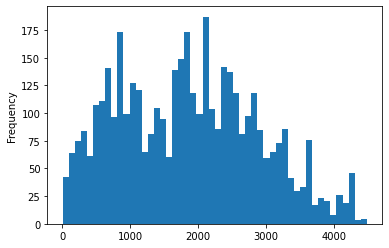

In [76]:
df_price['host_since'].dt.days.plot.hist(bins=50)

<AxesSubplot:>

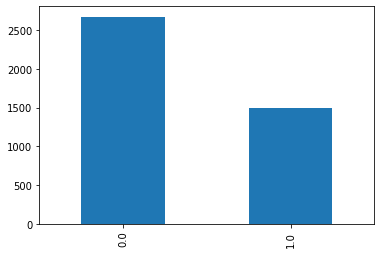

In [77]:
df_price['host_is_superhost'].value_counts().plot.bar()

In [78]:
type(df_price['host_since'][0])

pandas._libs.tslibs.timedeltas.Timedelta

In [79]:
df_price[df_price['host_since'].isna()]

neighbourhood  price  minimum_nights  availability_365  \
65    Kensington-Cedar Cottage    500               5                 0   
73    Kensington-Cedar Cottage     77              30               158   
129   Kensington-Cedar Cottage    125               4                20   
179                  Kitsilano    100              30               318   
242                  Kitsilano    457               7                 0   
383             Mount Pleasant    110              90                 0   
407                   Downtown     75             180               364   
435                 Kerrisdale     93               4               296   
471                   Downtown    199               1               365   
475                   Downtown    125              30               365   
531          Dunbar Southlands    119              30               130   
560                   Downtown    115              30                40   
610   Kensington-Cedar Cottage     35              30               316   
612   Kensington-Cedar Cottage     40              30               316   
618   Kensington-Cedar Cottage     45              30               316   
704          Downtown Eastside    207               2               352   
715   Kensington-Cedar Cottage    110              30                51   
742             Mount Pleasant    200               2               364   
805                     Sunset     39               1               144   
806                     Sunset     37               1               106   
861              Arbutus Ridge    150              30               317   
864          Dunbar Southlands     72              31               316   
892   Kensington-Cedar Cottage    650               7                 0   
903         Grandview-Woodland    100               4                 0   
905          Downtown Eastside    257               2               312   
968                   Downtown     89              30                74   
1000          Hastings-Sunrise     69               3                88   
1012                  Downtown    115              30                57   
1088        Grandview-Woodland    200              30               162   
1089                 Kitsilano    120              14               234   
1095                  Downtown    249               1               365   
1141                  Fairview     85              30                 0   
1166                  Oakridge    200               2                 0   
1183                  Downtown     92              30                79   
1259                  Fairview     85              30               245   
1268                  Fairview    100              30               217   
1292                  Fairview    110              30               154   
1316              South Cambie   1576               3               179   
1343                Kerrisdale     62              30                88   
1345                  Fairview     80              30               241   
1352                  Fairview    105              30               263   
1353                  Fairview     82              30               269   
1360                  Fairview     95              30               232   
1379                  Fairview     85              30               263   
1380                  Fairview     85              30               263   
1402                  Fairview    105              30               263   
1404                  Fairview     85              30               244   
1427                  Fairview     85              30                90   
1445        Grandview-Woodland     45              30                 0   
1451                  Fairview     85              30               219   
1452                  Fairview    100              30               215   
1508                  Fairview    105              30               365   
1509                  Fairview     85     

In [80]:
listings[listings['host_since'].isna()]

id                            listing_url       scrape_id  \
65      498112    https://www.airbnb.com/rooms/498112  20210412154228   
73      654763    https://www.airbnb.com/rooms/654763  20210412154228   
129    1361276   https://www.airbnb.com/rooms/1361276  20210412154228   
179    2183209   https://www.airbnb.com/rooms/2183209  20210412154228   
242    3258141   https://www.airbnb.com/rooms/3258141  20210412154228   
383    5873868   https://www.airbnb.com/rooms/5873868  20210412154228   
407    6405277   https://www.airbnb.com/rooms/6405277  20210412154228   
435    6939529   https://www.airbnb.com/rooms/6939529  20210412154228   
471    7701543   https://www.airbnb.com/rooms/7701543  20210412154228   
475    7748307   https://www.airbnb.com/rooms/7748307  20210412154228   
531    8703874   https://www.airbnb.com/rooms/8703874  20210412154228   
560    9615787   https://www.airbnb.com/rooms/9615787  20210412154228   
610   11546735  https://www.airbnb.com/rooms/11546735  20210412154228   
612   11550687  https://www.airbnb.com/rooms/11550687  20210412154228   
618   11688698  https://www.airbnb.com/rooms/11688698  20210412154228   
704   13416108  https://www.airbnb.com/rooms/13416108  20210412154228   
715   13607164  https://www.airbnb.com/rooms/13607164  20210412154228   
742   13968919  https://www.airbnb.com/rooms/13968919  20210412154228   
805   14757196  https://www.airbnb.com/rooms/14757196  20210412154228   
806   14775158  https://www.airbnb.com/rooms/14775158  20210412154228   
861   15582940  https://www.airbnb.com/rooms/15582940  20210412154228   
864   15635558  https://www.airbnb.com/rooms/15635558  20210412154228   
892   16339748  https://www.airbnb.com/rooms/16339748  20210412154228   
903   16673770  https://www.airbnb.com/rooms/16673770  20210412154228   
905   16740054  https://www.airbnb.com/rooms/16740054  20210412154228   
968   17907461  https://www.airbnb.com/rooms/17907461  20210412154228   
1000  18417080  https://www.airbnb.com/rooms/18417080  20210412154228   
1012  18525552  https://www.airbnb.com/rooms/18525552  20210412154228   
1088  19250702  https://www.airbnb.com/rooms/19250702  20210412154228   
1089  19251596  https://www.airbnb.com/rooms/19251596  20210412154228   
1095  19298482  https://www.airbnb.com/rooms/19298482  20210412154228   
1141  19805434  https://www.airbnb.com/rooms/19805434  20210412154228   
1166  20002260  https://www.airbnb.com/rooms/20002260  20210412154228   
1183  20235568  https://www.airbnb.com/rooms/20235568  20210412154228   
1259  21112252  https://www.airbnb.com/rooms/21112252  20210412154228   
1268  21188818  https://www.airbnb.com/rooms/21188818  20210412154228   
1292  21527208  https://www.airbnb.com/rooms/21527208  20210412154228   
1316  21787591  https://www.airbnb.com/rooms/21787591  20210412154228   
1343  22228696  https://www.airbnb.com/rooms/22228696  20210412154228   
1345  22231178  https://www.airbnb.com/rooms/22231178  20210412154228   
1352  22298691  https://www.airbnb.com/rooms/22298691  20210412154228   
1353  22298696  https://www.airbnb.com/rooms/22298696  20210412154228   
1360  22389548  https://www.airbnb.com/rooms/22389548  20210412154228   
1379  22659767  https://www.airbnb.com/rooms/22659767  20210412154228   
1380  22659967  https://www.airbnb.com/rooms/22659967  20210412154228   
1402  22903375  https://www.airbnb.com/rooms/22903375  20210412154228   
1404  22905570  https://www.airbnb.com/rooms/22905570  20210412154228   
1427  23172118  https://www.airbnb.com/rooms/23172118  20210412154228   
1445  23413748  https://www.airbnb.com/rooms/23413748  20210412154228   
1451  23482505  https://www.airbnb.com/rooms/23482505  20210412154228   
1452  23482800  https://www.airbnb.com/rooms/23482800  20210412154228   
1508  24066686  https://www.airbnb.com/rooms/24066686  20210412154228   
1509  24066913  https://www.airbnb.com/rooms/24066913  20210412154228   
1550  24474689  https://www.airbnb.com/rooms/24474689  20210412154228 

In [81]:
df_price.head(1).loc[:,(df_price.dtypes == 'int64' )| (df_price.dtypes == 'float64')]

price  minimum_nights  availability_365  calculated_host_listings_count  \
0    150              90               346                              40   

   host_response_rate  host_acceptance_rate  host_is_superhost  \
0                0.93                  0.87                0.0   

   host_has_profile_pic  host_identity_verified  accommodates  bathrooms_text  \
0                   1.0                     1.0             5             2.0   

   bedrooms  beds  instant_bookable  amenity_wifi  amenity_heating  \
0       2.0   2.0                 0           1.0              1.0   

   amenity_smoke alarm  amenity_essentials  amenity_kitchen  \
0                  1.0                 0.0              1.0   

   amenity_long term stays allowed  amenity_hangers  amenity_washer  \
0                              1.0              1.0             1.0   

   amenity_dryer  amenity_hair dryer  amenity_hot water  amenity_iron  \
0            1.0                 1.0                1.0           1.0   

   amenity_shampoo  amenity_dedicated workspace  amenity_tv  \
0              0.0                          1.0         0.0   

   amenity_carbon monoxide alarm  amenity_dishes and silverware  \
0                            1.0                            1.0   

   amenity_fire extinguisher  amenity_refrigerator  amenity_cooking basics  \
0                        0.0                   1.0                     1.0   

   amenity_microwave  amenity_coffee maker  amenity_stove  amenity_oven  \
0                1.0                   1.0            1.0           0.0   

   amenity_free parking on premises  amenity_private entrance  \
0                               1.0                       0.0   

   amenity_bed linens  amenity_free street parking  amenity_dishwasher  \
0                 1.0                          0.0                 1.0   

   amenity_first aid kit  amenity_patio or balcony  \
0                    0.0                       0.0   

   amenity_extra pillows and blankets  amenity_elevator  amenity_cable tv  \
0                                 0.0               1.0               1.0   

   amenity_luggage dropoff allowed  amenity_air conditioning  amenity_gym  \
0                              0.0                       1.0          1.0   

   amenity_backyard  number_of_reviews  number_of_reviews_ltm  \
0               0.0                 16                      0   

   number_of_reviews_l30d  reviews_per_month  review_scores_rating  \
0                       0               0.14                  93.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                     9.0                        9.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  
0                          9.0                    10.0                  9.0

In [82]:
# These columns are strings that will have to be converted to dummies
dummy_cols = df_price.columns[df_price.dtypes == 'object']
print(dummy_cols)

Index(['neighbourhood', 'host_response_time', 'room_type'], dtype='object')


In [83]:
df_price_dummied = pd.get_dummies(df_price, columns=dummy_cols, prefix=dummy_cols, drop_first=True)

In [84]:
df_price_dummied.head(1)

price  minimum_nights  availability_365  calculated_host_listings_count  \
0    150              90               346                              40   

  host_since  host_response_rate  host_acceptance_rate  host_is_superhost  \
0  4266 days                0.93                  0.87                0.0   

   host_has_profile_pic  host_identity_verified  accommodates  bathrooms_text  \
0                   1.0                     1.0             5             2.0   

   bedrooms  beds  instant_bookable  amenity_wifi  amenity_heating  \
0       2.0   2.0                 0           1.0              1.0   

   amenity_smoke alarm  amenity_essentials  amenity_kitchen  \
0                  1.0                 0.0              1.0   

   amenity_long term stays allowed  amenity_hangers  amenity_washer  \
0                              1.0              1.0             1.0   

   amenity_dryer  amenity_hair dryer  amenity_hot water  amenity_iron  \
0            1.0                 1.0                1.0           1.0   

   amenity_shampoo  amenity_dedicated workspace  amenity_tv  \
0              0.0                          1.0         0.0   

   amenity_carbon monoxide alarm  amenity_dishes and silverware  \
0                            1.0                            1.0   

   amenity_fire extinguisher  amenity_refrigerator  amenity_cooking basics  \
0                        0.0                   1.0                     1.0   

   amenity_microwave  amenity_coffee maker  amenity_stove  amenity_oven  \
0                1.0                   1.0            1.0           0.0   

   amenity_free parking on premises  amenity_private entrance  \
0                               1.0                       0.0   

   amenity_bed linens  amenity_free street parking  amenity_dishwasher  \
0                 1.0                          0.0                 1.0   

   amenity_first aid kit  amenity_patio or balcony  \
0                    0.0                       0.0   

   amenity_extra pillows and blankets  amenity_elevator  amenity_cable tv  \
0                                 0.0               1.0               1.0   

   amenity_luggage dropoff allowed  amenity_air conditioning  amenity_gym  \
0                              0.0                       1.0          1.0   

   amenity_backyard  number_of_reviews  number_of_reviews_ltm  \
0               0.0                 16                      0   

   number_of_reviews_l30d first_review last_review  reviews_per_month  \
0                       0    3439 days   1509 days               0.14   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  93.0                     9.0                        9.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                          9.0                    10.0   

   review_scores_value  neighbourhood_Downtown  \
0                  9.0                       1   

   neighbourhood_Downtown Eastside  neighbourhood_Dunbar Southlands  \
0                                0                                0   

   neighbourhood_Fairview  neighbourhood_Grandview-Woodland  \
0                       0                                 0   

   neighbourhood_Hastings-Sunrise  neighbourhood_Kensington-Cedar Cottage  \
0                               0                                       0   

   neighbourhood_Kerrisdale  neighbourhood_Killarney  neighbourhood_Kitsilano  \
0                         0                        0                        0   

   neighbourhood_Marpole  neighbourhood_Mount Pleasant  \
0                      0                             0   

   neighbourhood_Oakridge  neighbourhood_Renfrew-Collingwood  \
0                       0                                  0   

   neighbourhood_Riley Park  neighbourhood_Shaughnessy  \
0                         0                          0   

   neighbourhood_South Cambie  neighbourhood_Strath

In [85]:
df_price_dummied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 94 columns):
 #   Column                                  Non-Null Count  Dtype          
---  ------                                  --------------  -----          
 0   price                                   4299 non-null   int64          
 1   minimum_nights                          4299 non-null   int64          
 2   availability_365                        4299 non-null   int64          
 3   calculated_host_listings_count          4299 non-null   int64          
 4   host_since                              4170 non-null   timedelta64[ns]
 5   host_response_rate                      2991 non-null   float64        
 6   host_acceptance_rate                    3099 non-null   float64        
 7   host_is_superhost                       4170 non-null   float64        
 8   host_has_profile_pic                    4170 non-null   float64        
 9   host_identity_verified                  4

In [86]:
df_price_dummied_filled = df_price_dummied.fillna(df_price_dummied.median())

In [87]:
df_price_dummied.shape

(4299, 94)

In [88]:
# rename
df_pdf = df_price_dummied_filled.copy()

In [89]:
df_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 94 columns):
 #   Column                                  Non-Null Count  Dtype          
---  ------                                  --------------  -----          
 0   price                                   4299 non-null   int64          
 1   minimum_nights                          4299 non-null   int64          
 2   availability_365                        4299 non-null   int64          
 3   calculated_host_listings_count          4299 non-null   int64          
 4   host_since                              4299 non-null   timedelta64[ns]
 5   host_response_rate                      4299 non-null   float64        
 6   host_acceptance_rate                    4299 non-null   float64        
 7   host_is_superhost                       4299 non-null   float64        
 8   host_has_profile_pic                    4299 non-null   float64        
 9   host_identity_verified                  4

<AxesSubplot:>

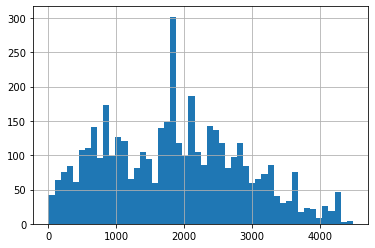

In [90]:
df_pdf['host_since'].dt.days.hist(bins=50)

In [91]:
# Change timedelta to days
cols_td = df_pdf.columns[df_pdf.dtypes == "timedelta64[ns]"]
df_pdf[cols_td] = df_pdf[cols_td].apply(lambda x: x.dt.days)

In [92]:
X = df_pdf.loc[:,~(df_pdf.columns == 'price')]

In [93]:
X.shape

(4299, 93)

In [94]:
y = df['price']

In [95]:
y.shape

(4299,)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 7, test_size = 0.3)

In [97]:
lm_model = LinearRegression(normalize=True)

In [98]:
lm_model.fit(X_train, y_train)

LinearRegression(normalize=True)

In [99]:
y_preds = lm_model.predict(X_test)

In [100]:
r_score = r2_score(y_test, y_preds)

In [101]:
print(r_score)

0.4209043072315708


In [102]:
lm_model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': True,
 'positive': False}

In [103]:
y_test

3770      85
2320      54
1470     300
652      185
2796     250
638      279
325      330
3597      37
3653      88
2348      31
2420      68
1774      40
1962      68
1788      75
1096     300
1758      74
2449      90
194      125
3905      33
513      245
3691      98
3859      55
2462     150
3033     135
4273     132
2966     134
3789      90
2645     496
2084     110
4183      99
540       95
2132     189
578       87
1420      80
2212      70
1558     259
2403      85
658      159
2799     157
4292      59
1690     190
3479     259
1255      92
3110     119
4089      80
3572     101
2006      42
2123     200
2356     181
1244     169
2959     283
2325     105
3570     275
2644     180
2280     200
718      350
511      110
1533     103
3938     309
1402     105
3173      69
2409     185
2074     296
3801     110
362       99
687       31
2584     120
887      125
2742      79
378      424
533      105
1511     150
48       110
1440     139
3402     188
1619     107
3023      97

In [104]:
y_test_reset = y_test.reset_index(drop=True)

In [105]:
results = pd.concat([pd.Series(y_preds), y_test_reset, y_preds - y_test_reset, (y_preds - y_test_reset)/y_test_reset], axis=1)
print(results)

               0  price        price     price
0      86.332198     85     1.332198  0.015673
1     115.248121     54    61.248121  1.134224
2     270.552914    300   -29.447086 -0.098157
3     168.827910    185   -16.172090 -0.087417
4     160.507479    250   -89.492521 -0.357970
5     215.355092    279   -63.644908 -0.228118
6     327.908156    330    -2.091844 -0.006339
7      72.577814     37    35.577814  0.961563
8     116.969339     88    28.969339  0.329197
9     -56.367943     31   -87.367943 -2.818321
10     42.881501     68   -25.118499 -0.369390
11      6.013365     40   -33.986635 -0.849666
12     71.004133     68     3.004133  0.044178
13     58.025204     75   -16.974796 -0.226331
14    258.437463    300   -41.562537 -0.138542
15    143.423623     74    69.423623  0.938157
16    141.158657     90    51.158657  0.568430
17    142.243880    125    17.243880  0.137951
18    137.691998     33   104.691998  3.172485
19    141.808452    245  -103.191548 -0.421190
20    215.109

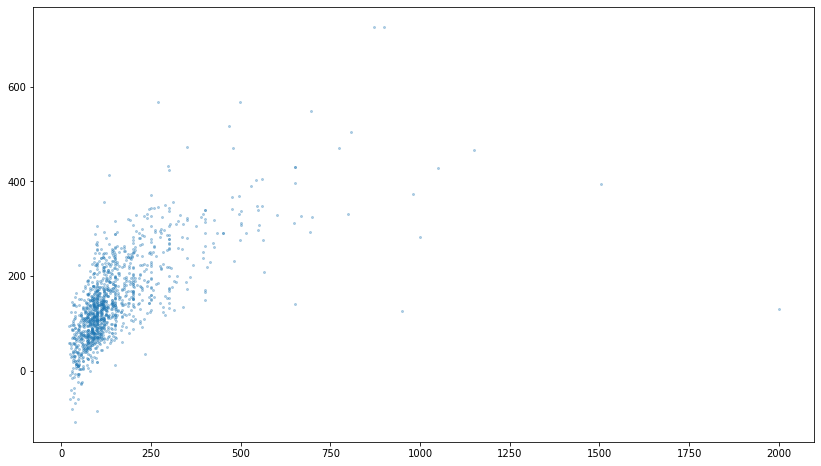

In [106]:
plt.figure(figsize=(14,8))
plt.scatter(y_test_reset, y_preds, s=4, alpha=0.3);


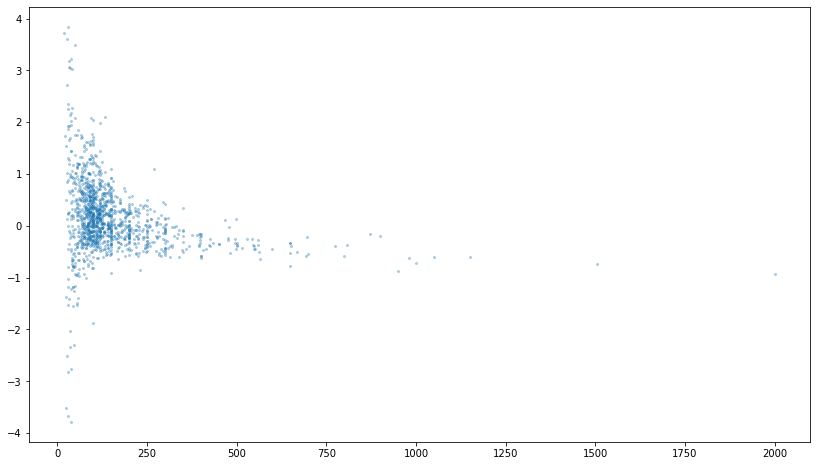

In [107]:
plt.figure(figsize=(14,8))
plt.scatter(y_test_reset, (y_preds - y_test_reset)/y_test_reset, s=4, alpha=0.3);

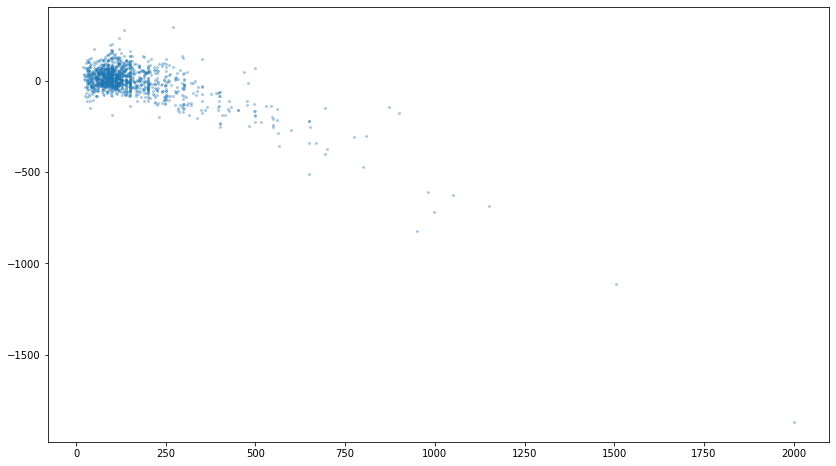

In [108]:
plt.figure(figsize=(14,8))
plt.scatter(y_test_reset, y_preds - y_test_reset, s=4, alpha=0.3);

In [109]:
coefs = pd.concat([X.columns.to_series().reset_index(drop=True), pd.Series(lm_model.coef_)], axis=1)
coefs.columns = ['feature', 'coef']
print(coefs)

                                   feature       coef
0                           minimum_nights   0.011563
1                         availability_365   0.056283
2           calculated_host_listings_count  -0.746261
3                               host_since  -0.000623
4                       host_response_rate  35.394141
5                     host_acceptance_rate  11.857039
6                        host_is_superhost  -4.468382
7                     host_has_profile_pic  27.161404
8                   host_identity_verified  -3.941618
9                             accommodates  13.657067
10                          bathrooms_text  57.323241
11                                bedrooms  23.684213
12                                    beds  -0.874419
13                        instant_bookable   5.293021
14                            amenity_wifi -81.656313
15                         amenity_heating  14.428727
16                     amenity_smoke alarm  22.830381
17                      amen

In [110]:
coefs.sort_values(by='coef')

feature       coef
90                    room_type_Hotel room -95.802314
14                            amenity_wifi -81.656313
73                 neighbourhood_Killarney -67.679007
84       neighbourhood_Victoria-Fraserview -56.883685
92                   room_type_Shared room -52.535565
17                      amenity_essentials -45.365171
70          neighbourhood_Hastings-Sunrise -45.154474
75                   neighbourhood_Marpole -36.424792
83                    neighbourhood_Sunset -35.246469
69        neighbourhood_Grandview-Woodland -34.554964
77                  neighbourhood_Oakridge -33.986350
91                  room_type_Private room -33.514789
71  neighbourhood_Kensington-Cedar Cottage -24.573295
76            neighbourhood_Mount Pleasant -20.462537
89       host_response_time_within an hour -19.755235
78       neighbourhood_Renfrew-Collingwood -18.838844
88   host_response_time_within a few hours -15.767617
34                       amenity_microwave -12.893230
79                neighbourhood_Riley Park -12.779132
87         host_response_time_within a day -12.191129
19         amenity_long term stays allowed -12.155132
40                      amenity_bed linens -11.999125
30           amenity_dishes and silverware -11.321327
27             amenity_dedicated workspace -11.245793
29           amenity_carbon monoxide alarm -10.296234
61                   review_scores_checkin -10.184308
21                          amenity_washer  -9.721824
68                  neighbourhood_Fairview  -9.433888
64                     review_scores_value  -9.005353
25                            amenity_iron  -7.436753
23                      amenity_hair dryer  -4.860214
80               neighbourhood_Shaughnessy  -4.551562
6                        host_is_superhost  -4.468382
8                   host_identity_verified  -3.941618
51                        amenity_backyard  -2.457676
36                           amenity_stove  -2.280406
41             amenity_free street parking  -2.030963
33                  amenity_cooking basics  -1.993182
37                            amenity_oven  -1.234248
53                   number_of_reviews_ltm  -1.074714
12                                    beds  -0.874419
2           calculated_host_listings_count  -0.746261
18                         amenity_kitchen  -0.364185
52                       number_of_reviews  -0.262305
3                               host_since  -0.000623
0                           minimum_nights   0.011563
56                             last_review   0.017359
55                            first_review   0.021023
62             review_scores_communication   0.045537
1                         availability_365   0.056283
66         neighbourhood_Downtown Eastside   0.191549
24                       amenity_hot water   0.323285
67         neighbourhood_Dunbar Southlands   0.523365
54                  number_of_reviews_l30d   0.859580
58                    review_scores_rating   1.259145
38        amenity_free parking on premises   1.553680
39                amenity_private entrance   1.726294
28                              amenity_tv   1.732566
47                        amenity_cable tv   1.826969
50                             amenity_gym   2.301088
44                amenity_patio or balcony   2.361769
46                        amenity_elevator   2.688948
59                  review_scores_accuracy   3.956455
31               amenity_fire extinguisher   4.043591
32                    amenity_refrigerator   4.469586
13                        instant_bookable   5.293021
60               review_scores_cleanliness   5.822020
63                  review_scores_location   6.131323
35                    amenity_coffee maker   6.362648
43                   amenity_first aid kit   6.477741
65                  neighbourhood_Downtown   7.068839
22                           amenity_dryer   7.560663
48         amenity_luggage dropoff allowed   9.134068
85                  neighbourhood_West 

In [111]:
for i, col in enumerate(X.columns):
    print(X.columns[i] + " " + str(np.round(lm_model.coef_[i], decimals=3)))

minimum_nights 0.012
availability_365 0.056
calculated_host_listings_count -0.746
host_since -0.001
host_response_rate 35.394
host_acceptance_rate 11.857
host_is_superhost -4.468
host_has_profile_pic 27.161
host_identity_verified -3.942
accommodates 13.657
bathrooms_text 57.323
bedrooms 23.684
beds -0.874
instant_bookable 5.293
amenity_wifi -81.656
amenity_heating 14.429
amenity_smoke alarm 22.83
amenity_essentials -45.365
amenity_kitchen -0.364
amenity_long term stays allowed -12.155
amenity_hangers 14.349
amenity_washer -9.722
amenity_dryer 7.561
amenity_hair dryer -4.86
amenity_hot water 0.323
amenity_iron -7.437
amenity_shampoo 30.633
amenity_dedicated workspace -11.246
amenity_tv 1.733
amenity_carbon monoxide alarm -10.296
amenity_dishes and silverware -11.321
amenity_fire extinguisher 4.044
amenity_refrigerator 4.47
amenity_cooking basics -1.993
amenity_microwave -12.893
amenity_coffee maker 6.363
amenity_stove -2.28
amenity_oven -1.234
amenity_free parking on premises 1.554
amen

# Predicting rating


In [113]:
df_pdf.columns

Index(['price', 'minimum_nights', 'availability_365',
       'calculated_host_listings_count', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bathrooms_text', 'bedrooms',
       'beds', 'instant_bookable', 'amenity_wifi', 'amenity_heating',
       'amenity_smoke alarm', 'amenity_essentials', 'amenity_kitchen',
       'amenity_long term stays allowed', 'amenity_hangers', 'amenity_washer',
       'amenity_dryer', 'amenity_hair dryer', 'amenity_hot water',
       'amenity_iron', 'amenity_shampoo', 'amenity_dedicated workspace',
       'amenity_tv', 'amenity_carbon monoxide alarm',
       'amenity_dishes and silverware', 'amenity_fire extinguisher',
       'amenity_refrigerator', 'amenity_cooking basics', 'amenity_microwave',
       'amenity_coffee maker', 'amenity_stove', 'amenity_oven',
       'amenity_free parking on premises', 'amenity_private entrance',
       'amenity_be

In [115]:
df_review = df_pdf.drop(labels=['number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'reviews_per_month',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value'], axis=1).copy()

In [116]:
y2 = df_review['review_scores_rating']
X2 = df_review.drop(labels=['review_scores_rating'], axis=1)

In [118]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=7, test_size=0.3)

In [119]:
lm_model2 = LinearRegression(normalize=True)

In [120]:
lm_model2.fit(X2_train, y2_train)

LinearRegression(normalize=True)

In [122]:
y2_preds = lm_model2.predict(X2_test)

In [124]:
r_score = r2_score(y2_test, y2_preds)
print(r_score)

0.09643978129731323


In [125]:
y2_test_reset = y2_test.reset_index(drop=True)
results2 = pd.concat([pd.Series(y2_preds), y2_test_reset, y2_preds - y2_test_reset, (y2_preds - y2_test_reset)/y2_test_reset], axis=1)
print(results2)

               0  review_scores_rating  review_scores_rating  \
0      98.224642                 100.0             -1.775358   
1      97.983088                  92.0              5.983088   
2      95.982699                  97.0             -1.017301   
3      94.460360                  93.0              1.460360   
4      93.672712                  97.0             -3.327288   
5      99.177345                  97.0              2.177345   
6      94.937770                  99.0             -4.062230   
7      94.443967                  97.0             -2.556033   
8      97.358338                  97.0              0.358338   
9      94.384106                  70.0             24.384106   
10     97.986641                  98.0             -0.013359   
11     96.285079                  96.0              0.285079   
12     92.885915                  94.0             -1.114085   
13     92.171540                  88.0              4.171540   
14     93.796572                  93.0  

(0.0, 120.0)

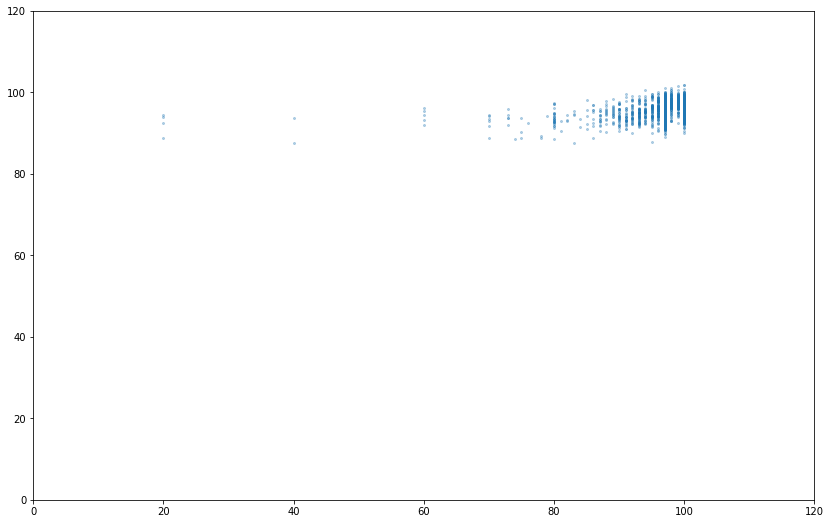

In [130]:
plt.figure(figsize=(14,9))
plt.scatter(y2_test_reset, y2_preds,  s=4, alpha=0.3)
plt.xlim(0,120)
plt.ylim(0,120)

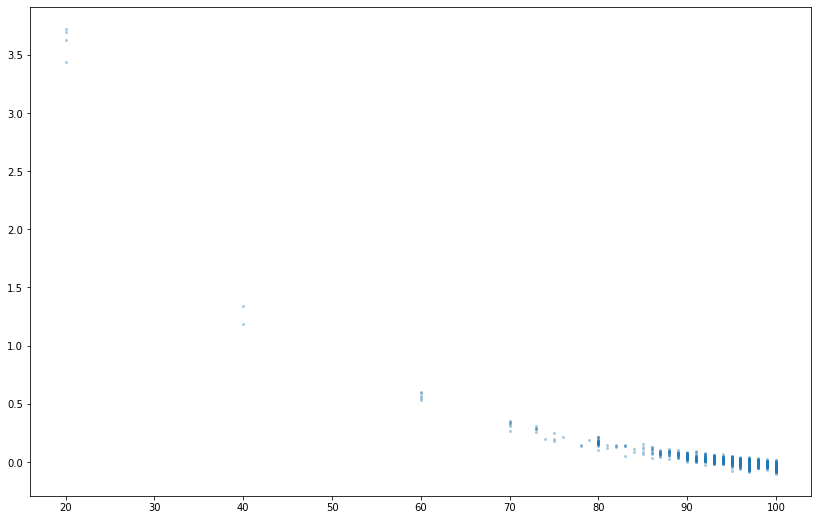

In [132]:
plt.figure(figsize=(14,9))
plt.scatter(y2_test_reset, (y2_preds - y2_test_reset)/y2_test_reset, s=4, alpha=0.3);

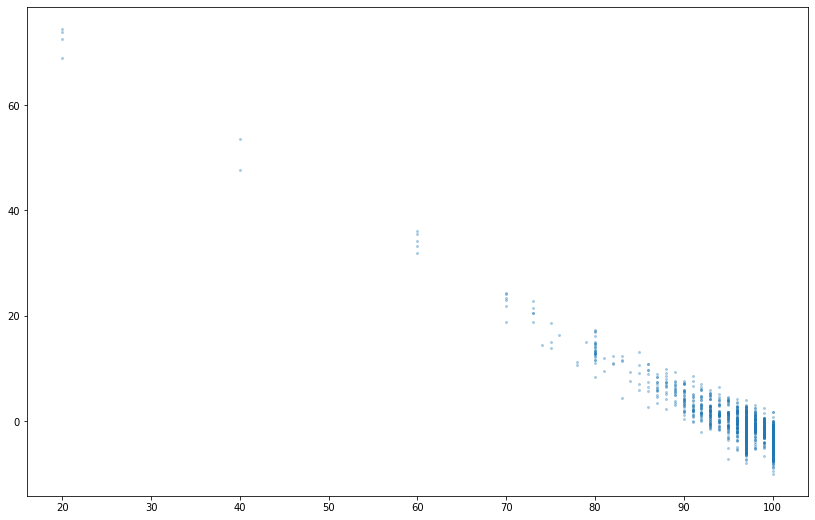

In [133]:
plt.figure(figsize=(14,9))
plt.scatter(y2_test_reset, (y2_preds - y2_test_reset), s=4, alpha=0.3);

In [134]:
coefs2 = pd.concat([X2.columns.to_series().reset_index(drop=True), pd.Series(lm_model2.coef_)], axis=1)
coefs2.columns = ['feature', 'coef']
print(coefs2)

                                   feature       coef
0                                    price   0.002555
1                           minimum_nights   0.010248
2                         availability_365  -0.000648
3           calculated_host_listings_count  -0.031159
4                               host_since   0.000341
5                       host_response_rate   1.503711
6                     host_acceptance_rate  -1.752124
7                        host_is_superhost   2.584772
8                     host_has_profile_pic  -1.105079
9                   host_identity_verified   0.025170
10                            accommodates  -0.127626
11                          bathrooms_text   0.003361
12                                bedrooms   0.242574
13                                    beds  -0.208579
14                        instant_bookable  -0.447266
15                            amenity_wifi  -1.499289
16                         amenity_heating  -0.552804
17                     ameni

In [136]:
coefs2.sort_values(by='coef')

feature       coef
78                    room_type_Hotel room -22.631525
80                   room_type_Shared room  -4.828627
6                     host_acceptance_rate  -1.752124
37                           amenity_stove  -1.606007
15                            amenity_wifi  -1.499289
18                      amenity_essentials  -1.260786
8                     host_has_profile_pic  -1.105079
20         amenity_long term stays allowed  -0.724191
75         host_response_time_within a day  -0.705376
33                    amenity_refrigerator  -0.621791
16                         amenity_heating  -0.552804
22                          amenity_washer  -0.532038
50                amenity_air conditioning  -0.481215
79                  room_type_Private room  -0.468948
14                        instant_bookable  -0.447266
19                         amenity_kitchen  -0.416683
77       host_response_time_within an hour  -0.385757
27                         amenity_shampoo  -0.372188
30           amenity_carbon monoxide alarm  -0.342773
47                        amenity_elevator  -0.311394
76   host_response_time_within a few hours  -0.232755
13                                    beds  -0.208579
39        amenity_free parking on premises  -0.205186
49         amenity_luggage dropoff allowed  -0.204825
41                      amenity_bed linens  -0.188526
42             amenity_free street parking  -0.163873
48                        amenity_cable tv  -0.142182
10                            accommodates  -0.127626
26                            amenity_iron  -0.110574
31           amenity_dishes and silverware  -0.091790
3           calculated_host_listings_count  -0.031159
2                         availability_365  -0.000648
4                               host_since   0.000341
0                                    price   0.002555
11                          bathrooms_text   0.003361
21                         amenity_hangers   0.007077
1                           minimum_nights   0.010248
9                   host_identity_verified   0.025170
28             amenity_dedicated workspace   0.032782
32               amenity_fire extinguisher   0.088001
52                        amenity_backyard   0.111538
36                    amenity_coffee maker   0.177260
51                             amenity_gym   0.193375
40                amenity_private entrance   0.196454
25                       amenity_hot water   0.212593
46      amenity_extra pillows and blankets   0.218409
24                      amenity_hair dryer   0.233842
12                                bedrooms   0.242574
45                amenity_patio or balcony   0.314524
35                       amenity_microwave   0.441890
34                  amenity_cooking basics   0.471134
23                           amenity_dryer   0.552713
44                   amenity_first aid kit   0.862520
43                      amenity_dishwasher   1.039630
29                              amenity_tv   1.240048
63                   neighbourhood_Marpole   1.265097
38                            amenity_oven   1.290077
74           neighbourhood_West Point Grey   1.328558
65                  neighbourhood_Oakridge   1.367338
5                       host_response_rate   1.503711
53                  neighbourhood_Downtown   1.542507
68               neighbourhood_Shaughnessy   1.579766
69              neighbourhood_South Cambie   1.606128
66       neighbourhood_Renfrew-Collingwood   1.615795
72       neighbourhood_Victoria-Fraserview   1.680412
62                 neighbourhood_Kitsilano   1.700428
54         neighbourhood_Downtown Eastside   1.802669
57        neighbourhood_Grandview-Woodland   1.939632
56                  neighbourhood_Fairview   1.974503
64            neighbourhood_Mount Pleasant   2.128036
55         neighbourhood_Dunbar Southlands   2.146746
17                     amenity_smoke alarm   2.211845
58          neighbourhood_Hastings-Sunrise   2.214854
60                neighbourhood_Kerrisd

check what happens when drop extremes for r2 scores